In [86]:
import patsy as pa
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd

tfd = tfp.distributions

from PriorLearning.elicitation_wrapper import expert_model
from PriorLearning.training import trainer
from PriorLearning.helper_functions import group_obs, Exponential_unconstrained, Normal_unconstrained, TruncatedNormal_unconstrained
from PriorLearning.user_config import target_config, target_input
from PriorLearning.helper_functions import _print_restab
from PriorLearning._case_studies import sleep_data_predictor, plot_expert_pred, tab_expert_pred, plot_loss, plot_priors, print_target_info
import PriorLearning.combine_losses 

from tabulate import tabulate
import pprint
pp = pprint.PrettyPrinter(depth=4)

tf.random.set_seed(2024)

# Normal Mutlilevel Model Model

## Background: Case Study
The accompanying example in this case study draws inspiration from the *sleepstudy* dataset (Belenky et al., 2003) that comes along with the R-package *lme4* (Bates et al., 2014). This dataset contains information about the average reaction time (RT) in milliseconds for $N$ individuals who undergo sleep deprivation for nine consecutive nights (with less than three hours of sleep per night). In order to construct a model for this data, we consider a hierarchical model with days serving as a continuous predictor denoted as $x$.

**References**

+ Belenky, G., Wesensten, N. J., Thorne, D. R., Thomas, M. L., Sing, H. C., Redmond, D. P., ... & Balkin, T. J. (2003). Patterns of performance degradation and restoration during sleep restriction and subsequent recovery: A sleep dose‐response study. *Journal of sleep research*, 12(1), 1-12.
+ Bates, D., Mächler, M., Bolker, B., & Walker, S. (2015). Fitting Linear Mixed-Effects Models Using lme4. *Journal of Statistical Software*, 67, 1-48.
  
## Data generating model
\begin{align}
    \begin{split}
    y_{ij} &= \textrm{Normal}(\theta_{ij}, s)\\
    \theta_{ij} &= \beta_{0,j} + \beta_{1,j} x_{ij} \\
    \beta_{0,j} &= \beta_0 + u_{0,j} \\
    \beta_{1,j} &= \beta_1 + u_{1,j} \\
    ( u_{0,j}, u_{1,j} ) &\sim \textrm{MvNormal}\left(\textbf{0}, \Sigma_u\right) \\
    \Sigma_u &= \begin{pmatrix}\tau_0^2 & \rho_{01} \tau_0 \tau_1 \\ \rho_{01} \tau_0 \tau_1 & \tau_1^2\end{pmatrix} \\
    \beta_k &\sim \textrm{Normal}(\mu_k, \sigma_k) \qquad\textrm{ for } k=0,1\\
    \tau_k &\sim \textrm{TruncatedNormal}(0, \omega_k) \qquad\textrm{for } k=0,1\\
    \rho_{01} &\sim \textrm{LKJ}(\alpha_\textrm{LKJ}) \\
    s &\sim \textrm{Exponential}(\nu).
    \end{split}
\end{align}
Here $y_{ij}$ represents the average RT for the $j^{th}$ participant at the $i^{th}$ day with $j=1,\ldots, 100$ and $i=0,\ldots,9$. 
The original *sleepstudy* dataset comprises only 18 participants. However, our objective is to assess the validity of our elicitation method by recovering each model (hyper)parameter accurately. To achieve this goal and capture the precise variability indicated by the varying effects, it was necessary to employ a larger sample size.
The RT data is assumed to follow a normal distribution with local mean $\theta_{ij}$ and within-person standard deviation $s$. Here, $\theta_{ij}$ is predicted by a linear combination of the continuous predictor $x$ with overall slope $\beta_1$ and intercept $\beta_0$. 
Given the potential variation in both baseline and change in RT across participants, the model incorporates varying (i.e., ``random'') intercepts $u_{0,j}$ and varying slopes $u_{1,j}$. These varying intercepts and slopes follow a multivariate normal distribution, centered at a mean vector of zero and with a covariance matrix $\Sigma_u$. This encodes the variability ($\tau_0, \tau_1$) and the correlation ($\rho_{01}$) between $u_{0,j}$ and $u_{1,j}$. 


## Methodology: Workflow
 
+ General procedure:
    + Draw samples from prior distribution(s) of model parameters 
    + Generate prior predictions according to the data generating model
    + Compute the pre-defined target quantities
    + Compute the elicited statistics of the target quantities
    + Measure the discrepancy between the model-implied and the expert elicited statistics
    + Update the weights of the transformation function of the normalizing flow  


+ PriorSamples($\lambda = (\mu_k, \sigma_k)$):
\begin{align*}
\{\beta_k\}_s &\sim \text{Normal}(\mu_k, \exp\{\sigma_k\})\\
\end{align*}
+ Generator($\beta_k$):
\begin{align*}
\{\text{log}(\theta_i)\}_s &= \{\beta_k\}_s \times X_i\\
\{y_i\}_s &\sim \text{Poisson}(\{\theta_i\}_s)\\
\end{align*}
+ Targets($\{y_j\}_s$, $\{\bar{y}_G\}_s$):
\begin{align*}
\{y_j\}_s &= \{y_j\}_s \quad \text{ for } j = 1,11,17,22,35,44\\
\{\bar{y}_G\}_s &= \frac{1}{\mid G \mid} \sum_{i\in G}\mathbb 1_G (\{y_i\}_s) \quad \text{ with G = Democratic, Republican, Swing}\\
\end{align*}
+ Elicits($\{y_{j}\}_s, \{R^2\}_s$)
\begin{align*}
\text{Histogram-based:}& \quad \{y_j\}_s = \{y_j\}_s \quad \text{ for } j = 1,11,17,22,35,44\\
\text{Quantile-based:}& \quad Q_p^{G} = Q_{p}^{G} \{\bar{y}_G\}_s \quad \text{G = Democratic, Republican, Swing, } p = 0.1, \ldots, 0.9\\
\end{align*}

## User specification

### Setting hyperparameter for the learning algorithm

In [87]:
# setting of hyperparameter of learning algorithm
user_config = dict(                    
        B = 2**7,                          
        rep = 300,                         
        epochs = 700,                      
        view_ep = 60,
        lr_decay = True,
        lr0 = 0.1, 
        lr_min = 0.00001, 
        loss_dimensions = "m,n:B",   
        loss_discrepancy = "energy", 
        loss_scaling = "unscaled",         
        method = "hyperparameter_learning"  
        )

# further case study specific variables
N_subj = 300 # number of participants
N_days = 10  # number of total days
selected_days = [0,2,4,6,8] # days for which the expert is queried
# get design matrix
dmatrix, cmatrix = sleep_data_predictor(scaling = "standardize", N_days = N_days, N_subj = N_subj, selected_days = selected_days)
pd.DataFrame(dmatrix).head(6)

,0,1
0,1.0,-1.566699
1,1.0,-0.870388
2,1.0,-0.174078
3,1.0,0.522233
4,1.0,1.218544
5,1.0,-1.566699


### Setup the 'ideal agent'
The following prior distributions are assumed: 
+ A normal distribution for the overall (i.e., ``fixed'') effects $\beta_k$ ($k = 0, 1$) with mean $\mu_k$ and standard deviation $\sigma_k$.
+ A truncated normal distribution centered at zero with a standard deviation of $\omega_k$, is employed for the person-specific variation $\tau_k$, which is constrained to be positive.
+ The correlation parameter $\rho_{01}$ follows a Lewandowski-Kurowicka-Joe (LKJ; Lewandowski, Kurowicka, & Joe, 2009) distribution with scale parameter $\alpha_\textrm{LKJ}$. In the subsequent context, we set  $\alpha_\textrm{LKJ}$ to 1. Additionally, an Exponential prior distribution with rate $\nu$ is used for the within-person (error) standard deviation $s$.
+ The goal is to learn seven hyperparameters $\lambda=(\mu_k,\sigma_k, \omega_k, \nu)$ based on expert knowledge.
+ The ideal expert is defined by the following true hyperparameters: $\lambda^*=(\mu_0=250.40, \mu_1=30.26, \sigma_0=7.27, \sigma_1=4.82, \omega_0=33.00, \omega_1=23.00, \nu=0.04)$.

**Reference**

Lewandowski, D., Kurowicka, D., & Joe, H. (2009). Generating random correlation matrices based on vines and extended onion method. Journal of multivariate analysis, 100(9), 1989-2001.

In [88]:
# true hyperparameter values for ideal_expert
true_values = dict({
    "mu": [250.40, 30.26],
    "sigma": [7.27, 4.82],
    "omega": [33., 23.],
    "alpha_lkj": 1.,
    "nu": 0.04
})

# model parameters
parameters_dict = {
    "beta_0": {
        "family":  Normal_unconstrained(),
        "true": tfd.Normal(true_values["mu"][0], true_values["sigma"][0]),
        "initialization": [tfd.Normal(240.,5.), tfd.Normal(1.,0.2)]
        },
    "beta_1": {
        "family":  Normal_unconstrained(),
        "true": tfd.Normal(true_values["mu"][1], true_values["sigma"][1]),
        "initialization": [tfd.Normal(40.,5.), tfd.Normal(1.,0.2)]
        },
    "tau_0": {
        "family": TruncatedNormal_unconstrained(loc = 0.,low = 0.,high = 500),
        "true":  tfd.TruncatedNormal(0., true_values["omega"][0], low=0., high=500),
        "initialization": [tfd.Normal(3.,0.5)]
        },
    "tau_1": {
        "family": TruncatedNormal_unconstrained(loc = 0.,low = 0.,high = 500),
        "true":  tfd.TruncatedNormal(0., true_values["omega"][1], low=0., high=500),
        "initialization": [tfd.Normal(3.,0.1)]
        },
    "sigma": {
        "family": Exponential_unconstrained(user_config["rep"]),
        "true": tfd.Exponential(true_values["nu"]),
        "initialization": [tfd.Normal(0., 0.1)]
        }
    }

print("True hyperparameter values:")
pd.DataFrame(true_values)

True hyperparameter values:


,mu,sigma,omega,alpha_lkj,nu
0,250.40,7.27,33.0,1.0,0.04
1,30.26,4.82,23.0,1.0,0.04


### Define the data generating model

In [89]:
# generative model
class GenerativeModel(tf.Module):
    def __call__(self, 
                 parameters,        # obligatory: samples from prior distributions; tf.Tensor
                 dmatrix,           # required: design matrix; tf.Tensor
                 alpha_lkj,
                 N_subj,
                 N_days,
                 **kwargs           # obligatory: possibility for further keyword arguments is needed 
                 ):  
        # correlation matrix
        corr_matrix = tfd.LKJ(2, alpha_lkj).sample((user_config["B"], user_config["rep"]))
        
        # SD matrix
        # shape = (B, 2)
        taus_m = tf.reduce_mean(
            tf.gather(parameters, indices=[2,3], axis=-1),
            axis=1)
        
        # shape = (B, 2, 2)
        S = tf.linalg.diag(taus_m)
        
        # covariance matrix: Cov=S*R*S
        # shape = (B, 2, 2)
        corr_mat = tf.linalg.diag(diagonal=(1.,1.), 
                                  padding_value=tf.reduce_mean(corr_matrix))
        # compute cov matrix
        # shape = (B, 2, 2)
        cov_mx_subj = tf.matmul(tf.matmul(S,corr_mat), S)
        
        # generate by-subject random effects: T0s, T1s
        # shape = (B, N_subj, 2)
        subj_rfx = tfd.Sample(
            tfd.MultivariateNormalTriL(
                loc= [0,0], 
                scale_tril=tf.linalg.cholesky(cov_mx_subj)), 
            N_subj).sample()
        
        # broadcast by-subject random effects
        # shape = (B, N_obs, 2) with N_obs = N_subj*N_days
        taus = tf.reshape(
            tf.broadcast_to(
                tf.expand_dims(subj_rfx, axis=2), 
                shape=(user_config["B"], N_subj, N_days, 2)), 
            shape=(user_config["B"], N_subj*N_days, 2))
        
        # reshape coefficients
        # shape = (B, rep, N_obs, 2) with N_obs = N_subj*N_days
        betas_reshaped = tf.broadcast_to(
            tf.expand_dims(
                tf.gather(parameters, indices=[0,1], axis=-1),
                axis=2), 
            shape=(user_config["B"], user_config["rep"], N_subj*N_days, 2))
        
        ## compute betas_s
        # shape = (B, rep, N_obs, 2) with N_obs = N_subj*N_days
        betas = tf.add(betas_reshaped, tf.expand_dims(taus, axis=1)) 
        
        # compute linear predictor term
        # shape = (B, rep, N_obs) with N_obs = N_subj*N_days
        epred = tf.add(betas[:,:,:,0]*dmatrix[:,0], 
                       betas[:,:,:,1]*dmatrix[:,1])
        
        # define likelihood
        likelihood = tfd.Normal(loc = epred,
                                scale = tf.expand_dims(parameters[:,:,-1],-1))
        
        # sample prior predictive data
        ypred = likelihood.sample()
        
        # custom target quantities 
        ## epred averaged over individuals
        epred_days = tf.stack([epred[:,:,i::N_days] for i in range(N_days)], 
                              axis = -1)
        epred_days = tf.reduce_mean(epred_days, axis=2)
        
        ## R2 for initial day
        R2_day0 = tf.divide(
            tf.math.reduce_variance(epred[:,:,selected_days[0]::N_days], axis=-1),
            tf.math.reduce_variance(ypred[:,:,selected_days[0]::N_days], axis=-1))
        
        ## R2 for last day
        R2_day9 = tf.divide(
            tf.math.reduce_variance(epred[:,:,selected_days[-1]::N_days], axis=-1),
            tf.math.reduce_variance(ypred[:,:,selected_days[-1]::N_days], axis=-1))
        # compute standard deviation of linear predictor 
        mu0_sd_comp = tf.math.reduce_std(epred[:,:,selected_days[0]::N_days], axis=-1)
        mu9_sd_comp = tf.math.reduce_std(epred[:,:,selected_days[-1]::N_days], axis=-1)
        
        return dict(likelihood = likelihood,      # obligatory: likelihood; callable; 
                    ypred = ypred,                # obligatory: prior predictive data
                    epred = epred,                # obligatory: samples from linear predictor
                    sigma = parameters[:,:,-1],   # optional: custom target quantity: sigma
                    epred_days = epred_days,      # optional: custom target quantity: epred avg. over individuals
                    R2_day0 = R2_day0,            # optional: custom target quantity: R2 first day
                    R2_day9 = R2_day9,             # optional: custom target quantity; R2 last day
                    mu0_sd_comp = mu0_sd_comp,
                    mu9_sd_comp = mu9_sd_comp
                    )

### Specify the target quantities and the elicitation technique

+ We elicit expert knowledge within both the parameter and observable space, underscoring the inherently \emph{hybrid} nature of our elicitation method.
+ The analyst queries the expert regarding the following target quantities: the expected average RT for specific days $x_i$, where $i = 0,2,4,6,8$, the within-person standard deviation $s$, and the expected distribution of $R^2$ for the initial and final days ($i = 0,9$).
+ We assume that the analyst employs quantile-based elicitation for the expected average RT per chosen day $x_i$.
+ For the within-person standard deviation $s$, a moment-based elicitation approach is used, asking the expert regarding both the expected mean and standard deviation of $s$.
+ Additionally, histogram-elicitation is utilized to query the expected $R^2$ distribution for each day.

In [90]:
# specify target quantity, elicitation technique and loss combination
#t1 = target_config(target="sigma", 
#                   elicitation="moments",
#                   combine_loss="by-stats",
#                   moments_specs=("mean", "sd"))
t1 = target_config(target="sigma", 
                   elicitation="histogram",
                   combine_loss="all")
t2 = target_config(target="epred_days", 
                   elicitation="quantiles",
                   combine_loss="by-group",
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t3 = target_config(target="mu0_sd_comp", 
                   elicitation="histogram",
                   combine_loss="all")
t4 = target_config(target="mu9_sd_comp", 
                   elicitation="histogram",
                   combine_loss="all")

target_info_expert = target_input(t1, t2, t3, t4)

# print summary of expert input
print_target_info(target_info_expert)

,target,elicitation,combine_loss,custom_target_function,quantiles_specs
0,sigma,histogram,all,None,None
1,epred_days,quantiles,by-group,None,"(10, 20, 30, 40, 50, 60, 70, 80, 90)"
2,mu0_sd_comp,histogram,all,None,None
3,mu9_sd_comp,histogram,all,None,None


## Simulate from the "ideal" expert

In [91]:
expert_res_list, prior_pred_res = expert_model(1, user_config["rep"],
                                   parameters_dict, GenerativeModel, target_info_expert,
                                   method = "ideal_expert",
                                   dmatrix = dmatrix,
                                   alpha_lkj = 1., N_subj = N_subj, N_days = len(selected_days))

# elicited statistics from the (ideal) expert
expert_res_list.keys()

dict_keys(['sigma_hist_0', 'epred_days_quant_1', 'mu0_sd_comp_hist_2', 'mu9_sd_comp_hist_3'])

In [92]:
# specify target quantity, elicitation technique and loss combination
# define a custom function using the output from the generative model 
class sdmu_day_init:
    def __init__(self, R2_day0_expert):
        self.R2_day0_expert = R2_day0_expert
    def __call__(self, ypred):
        day = selected_days[0]
        len_days = len(selected_days)
        sdmu = tf.sqrt(tf.multiply(self.R2_day0_expert,
                                   tf.math.reduce_variance(
                                       ypred[:,:,day::len_days], 
                                       axis=-1))
                       )
        return sdmu

class sdmu_day_last:
    def __init__(self, R2_day9_expert):
        self.R2_day9_expert = R2_day9_expert
    def __call__(self, ypred):
        day = selected_days[-1]
        len_days = len(selected_days)
        sdmu = tf.sqrt(tf.multiply(self.R2_day9_expert,
                                   tf.math.reduce_variance(
                                       ypred[:,:,day::len_days], 
                                       axis=-1))
                       )
        return sdmu

sdmu_day0 = sdmu_day_init(prior_pred_res["R2_day0"])
sdmu_day9 = sdmu_day_last(prior_pred_res["R2_day9"])

t3 = target_config(target="mu0_sd_comp", 
                   elicitation="histogram",
                   combine_loss="all",
                   custom_target_function=sdmu_day0)
t4 = target_config(target="mu9_sd_comp", 
                   elicitation="histogram",
                   combine_loss="all",
                   custom_target_function=sdmu_day9)


target_info_model = target_input(t1, t2, t3, t4)

## Learn the prior distributions

In [ ]:
res_dict = trainer(expert_res_list, user_config["B"], user_config["rep"],
                   parameters_dict, user_config["method"], GenerativeModel,
                   target_info_model, user_config, loss_balancing = True, save_vals = ["prior_preds","elicits"],
                   dmatrix = dmatrix, alpha_lkj = 1., N_subj = N_subj, N_days = len(selected_days))

epoch_time: 802.416ms
Epoch: 0, loss: 13.38887, lr: 0.100000
epoch_time: 331.910ms
Epoch: 60, loss: 7.16512, lr: 0.028243
epoch_time: 278.348ms
Epoch: 120, loss: 4.13031, lr: 0.007977
epoch_time: 349.971ms
Epoch: 180, loss: 3.98920, lr: 0.002253
epoch_time: 319.622ms
Epoch: 240, loss: 3.98388, lr: 0.000636
epoch_time: 311.128ms
Epoch: 300, loss: 3.98473, lr: 0.000180
epoch_time: 350.627ms
Epoch: 360, loss: 3.98043, lr: 0.000051
epoch_time: 379.632ms
Epoch: 420, loss: 3.97968, lr: 0.000014


## Results

### Loss function

In [51]:
res_dict["hyperparam_info"][0][-1]

[248.59026, 1.98032, 28.62452, 1.589315, 3.2088177, 3.1945412, -3.0982041]

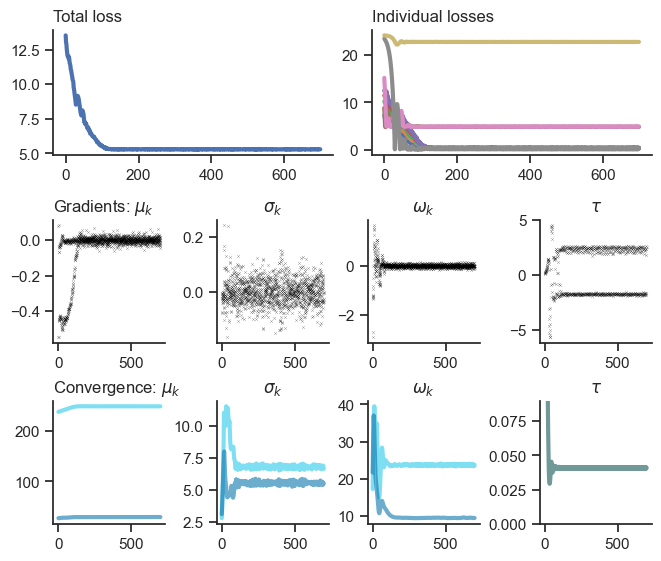

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

col_betas = ["#2acaea", "#0a75ad", "#ffd700", "#e86e4d", "#00ffaa", "#135553"]

g = tf.stack([res_dict["grads_info"][i] for i in range(user_config["epochs"])], -1)
p = tf.stack([res_dict["hyperparam_info"][0][i] for i in range(user_config["epochs"])], -1)

fig = plt.figure(layout='constrained', figsize=(6.5, 5.5))
figs = fig.subfigures(2,1, height_ratios = (1,2)) #

axs0 = figs[0].subplots(1,2)
axs1 = figs[1].subplots(2,4)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params) #, font = "Computer Modern"

axs0[0].plot(range(user_config["epochs"]), res_dict["loss_info"], lw = 3)
axs0[0].set_title("Total loss", loc = "left")
axs0[1].plot(range(user_config["epochs"]), res_dict["loss_indiv_info"], lw = 3)
axs0[1].set_title("Individual losses", loc = "left")

[sns.scatterplot(x = range(user_config["epochs"]), y = g[i,:], ax = axs1[0,0], marker = "x", s = 5, color = "black", alpha =.6) for i in [0,2]]
axs1[0,0].set_title(r"Gradients: $\mu_k$", loc = "left")
[sns.scatterplot(x = range(user_config["epochs"]), y = g[i,:], ax = axs1[0,1], marker = "x", s = 5, color = "black", alpha =.6) for i in [1,3]]
axs1[0,1].set_title(r"$\sigma_k$", loc = "center")
[sns.scatterplot(x = range(user_config["epochs"]), y = g[i,:], ax = axs1[0,2], marker = "x", s = 5, color = "black", alpha =.6) for i in [4,5]]
axs1[0,2].set_title(r"$\omega_k$", loc = "center")
sns.scatterplot(x = range(user_config["epochs"]), y = g[6,:], ax = axs1[0,3], marker = "x", s = 5, color = "black", alpha =.6) 
axs1[0,3].set_title(r"$\tau$", loc = "center")

[axs1[1,0].plot(range(user_config["epochs"]), p[j,:], color = col_betas[i], lw = 3, alpha = 0.6,
                  label = rf"$\mu_{i}$") for i,j in enumerate([0,2])]
axs1[1,0].set_title(r"Convergence: $\mu_k$", loc = "left")
[axs1[1,1].plot(range(user_config["epochs"]), tf.exp(p[j,:]), color = col_betas[i], lw = 3, alpha = 0.6,
                  label = rf"$\mu_{i}$") for i,j in enumerate([1,3])]
axs1[1,1].set_title(r"$\sigma_k$", loc = "center")
[axs1[1,2].plot(range(user_config["epochs"]), tf.exp(p[j,:]), color = col_betas[i], lw = 3, alpha = 0.6,
                  label = rf"$\omega_{i}$") for i,j in enumerate([4,5])]
axs1[1,2].set_title(r"$\omega_k$", loc = "center")
axs1[1,3].plot(range(user_config["epochs"]), tf.exp(p[6,:]), color = col_betas[5], lw = 3, alpha = 0.6) 
axs1[1,3].set_title(r"$\tau$", loc = "center")
axs1[1,3].set_ylim((0,0.09))
plt.show()

In [85]:
print(tf.gather(res_dict["hyperparam_info"][0][-1], [0,2]).numpy())
print(tf.exp(tf.gather(res_dict["hyperparam_info"][0][-1], [1,3])).numpy())
print(tf.exp(tf.gather(res_dict["hyperparam_info"][0][-1], [4,5])).numpy())
print(tf.exp(tf.gather(res_dict["hyperparam_info"][0][-1], [6])).numpy())
#tf.exp(res_dict["hyperparam_info"][0][-1][1::2])

[248.85254   29.496893]
[6.6198134 5.4781756]
[23.544441  9.481721]
[0.04101518]


In [29]:
print(tf.gather(prior_pred_res["hyperparam_info"][0][-1], [0,2]).numpy())
print(tf.exp(tf.gather(res_dict["hyperparam_info"][0][-1], [1,3])).numpy())
print(tf.exp(tf.gather(res_dict["hyperparam_info"][0][-1], [4,5])).numpy())
print(tf.exp(tf.gather(res_dict["hyperparam_info"][0][-1], [6])).numpy())

KeyError: 'hyperparam_info'

In [30]:
print(tf.math.reduce_mean(prior_pred_res["priors"], (0,1)))
print(tf.math.reduce_mean(res_dict['priors_info'][0]["priors"], (0,1)))

tf.Tensor([250.61543   30.006414  25.264902  18.826185  23.81099 ], shape=(5,), dtype=float32)
tf.Tensor([252.12589   30.321194  22.369932  18.646067  24.187828], shape=(5,), dtype=float32)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 3 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

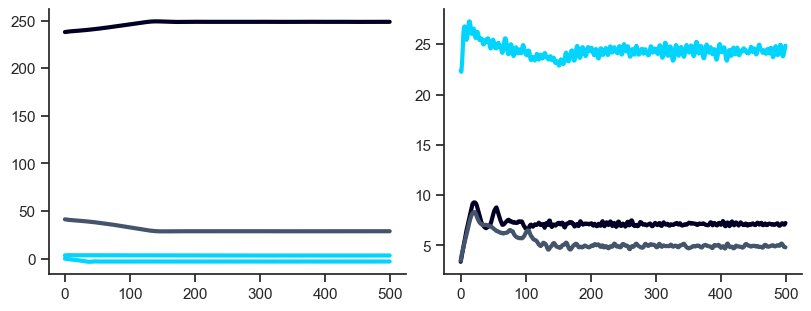

In [11]:
import matplotlib.pyplot as plt

betas = tf.stack([res_dict["hyperparam_info"][0][i][0::2] for i in range(user_config["epochs"])], -1)
sigmas =  tf.stack([tf.exp(res_dict["hyperparam_info"][0][i][1::2]) for i in range(user_config["epochs"])], -1)

_, axs = plt.subplots(1,2, constrained_layout = True, figsize = (8,3), sharex = True)
[axs[0].plot(betas[i,:], lw = 3, color = c, label = fr"$\mu_{i}$") for i,c in zip(range(4), ["#020024", "#44546A", "#00d4ff", "#00d4ff"])]
[axs[1].plot(sigmas[i,:], lw = 3, color = c, label = fr"$\sigma_{i}$") for i,c in zip(range(4), ["#020024", "#44546A", "#00d4ff", "#00d4ff"])]
[axs[i].legend(handlelength = 0.4, fontsize = "medium", ncol = 2, columnspacing = 0.5) for i in range(2)]
axs[0].set_title(r"$\mu_0, \mu_1, \mu_2, \mu_3$",pad = 10., fontdict = {'fontsize': 14}, loc = "left")
axs[1].set_title(r"$\sigma_0, \sigma_1, \sigma_2, \sigma_3$",pad = 10., fontdict = {'fontsize': 14}, loc = "left")
axs[1].set_xlabel("epochs")
plt.show()

### Final learned hyperparameter values

In [12]:
true_vals = [j for i in zip(true_values["mu"],true_values["sigma"]) for j in i]

tab, avg_res = _print_restab(method = "hyperparameter_learning", 
                             num_vars = 4, 
                             res = res_dict["hyperparam_info"], 
                             start = 5, 
                             precision = 3, 
                             true_values = true_vals)
tab

var_name,pred mean,pred std,true,err
loc_0,248.658,0.002,250.4,1.742
scale_0,7.095,0.036,7.27,0.175
loc_1,28.692,0.006,30.26,1.568
scale_1,4.904,0.077,4.82,0.084


### Learned prior distributions

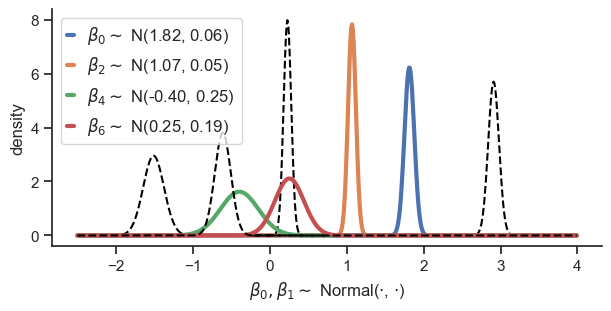

In [18]:
plot_priors(avg_res, true_vals, xrange = (-2.5, 4))